<a href="https://colab.research.google.com/github/drjhero/data294/blob/main/gedeckChapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis Tests

These tests help us determine if random chance may be responsible for an observed effect.

* **Null hypothesis** tests that random chance explains a difference.
* **Alternative hypothesis** is the counterpoint to the null hypothesis. This is typically the thing we hope to prove.
* **One-way test** counts chance results in only one direction.
* **Two-way test** counts chance results in two directions.

A hypothesis might be that price B produces a higher profit for a product we sell than price A. It is important to do hypothesis tests because we as people have a tendency to manufacture patterns even when we are looking at random data.

In the data analysis we do in this class we will likely compare data for two groups and we will want to understand if the differences between those groups comes from:
 * random chance in how the groups were picked
 * a true difference between the groups

 We may not have A/B tests so it will be more difficult to say our results are caused by properties of the groups, but we can still say the differences are significant.



## Null Hypothesis
 Gedeck defines the Null Hypothesis as, "Given the human tendency to react to unusual but random behavior and interpret is as something meaningful and real, in our analyses we will require proof that the difference between groups is more extreme than what chance might reasonably produce."

 Thus means in a null hypothesis test, by definition, we start with the ununtuitive assumption that the two groups **are the same**. The goal of the anlaysis is to prove this wrong.

 There is an intuitive way to perform this check similar to the bootstrapping resampling we did earlier. We can mix all the data from the two groups together into one big data set. Then we can randomly select from that data to create two new groups (same size as the original groups). This is exactly what the null hypothesis is trying to suss out. If we do this many times and the results are consistently similar to the originals, then the data is interchangeable and thus the null model is correct.



 ## Permutation Test
 **Permute** is defined as "submit to a process of alteration, rearrangement, or permutation". For our uses, we will permute the data in the two groups we want to compare. The permutation test for data from two groups (A and B) comprises the following steps
   1. Create a new data set by combining all the data from the two groups into one and randomize the order
   2. Randomly draw (without replacement) rows from the data set until we have as many rows as were originally in group A to create a new data set (modified A)
   3. Randomly draw (without replacement) rows from the data set until we have as many rows as were originally in group B to create a new data set (modified B)
   4. Compute the metric for each modified data set that you want to compare
   6. Repeat these steps *N* times keeping track of the metrics computed at each iteration

We can compare the difference between the original groups and aggregrate the differences across all the modified ones. If the difference in the original groups is within the set of the modified distances, then we have **not** proven the null hypothesis true (i.e., it could have just been chance).



### Web Stickiness Example
Imagine we work for a web company that sells a high-value product. We want to compare two different versions of the page that allows customers to buy this product, version A (the current version of the web site) and version B (one put together by our new hot shot marketing team).

The product is quite expensive and we don't want to wait for enough sales data to come in to determine which version is the best so we will measure results using a proxy variable: the amount of times customers spend on the target sales web page.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas  as pd
sessionTimes = pd.read_csv('/content/drive/MyDrive/Teaching/DATA 294/data/sessionTimes.csv')
sessionTimes.head()

,sessionTimeMinutes,version
0,2.772962,A
1,0.378777,A
2,2.322872,A
3,1.143629,A
4,1.059134,A


<Axes: xlabel='version', ylabel='sessionTimeMinutes'>

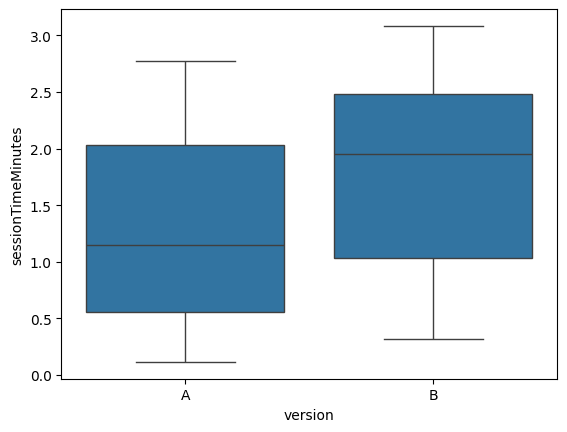

In [4]:
import seaborn as sea
sea.boxplot(x="version", y="sessionTimeMinutes", data=sessionTimes)

In [5]:
originalA = sessionTimes.loc[sessionTimes['version'] == 'A']
originalA = originalA.drop(columns=['version'])
originalB = sessionTimes.loc[sessionTimes['version'] == 'B']
originalB = originalB.drop(columns=['version'])
originalA.mean()

sessionTimeMinutes    1.313191
dtype: float64

In [6]:
originalB.mean()

sessionTimeMinutes    1.797602
dtype: float64

In [31]:
originalMeanDifference = originalB.mean() - originalA.mean()
originalMeanDifference = originalMeanDifference.max() # Max to get a scalar instead of a DataFrame
originalMeanDifference

0.48441060247333345

Group B *apparently* has longer session times, but if we assume the two groups were equal, could random chance explain this difference?

In [8]:
def permutationTestIteration(combinedDataFrame, groupASize, groupBSize):
  modifiedA = combinedDataFrame.sample(groupASize) # Default is without replacement
  modifiedB = combinedDataFrame.sample(groupBSize)
  return modifiedB.mean() - modifiedA.mean()

In [35]:
combinedDataFrame = pd.concat([originalA, originalB])
originalASize = len(originalA.index)
originalBSize = len(originalB.index)

iterations = 1000
permutationDifferences = [permutationTestIteration(combinedDataFrame, originalASize, originalBSize) for _ in range(iterations)]
df = pd.DataFrame(permutationDifferences)
df.head()

,sessionTimeMinutes
0,0.098339
1,0.178706
2,0.004017
3,0.064456
4,0.121307


In [30]:
df.mean()

sessionTimeMinutes    0.002492
dtype: float64

In [39]:
df.quantile([0.025, 0.975])

,sessionTimeMinutes
0.025,-0.426334
0.975,0.439625


<Axes: ylabel='Count'>

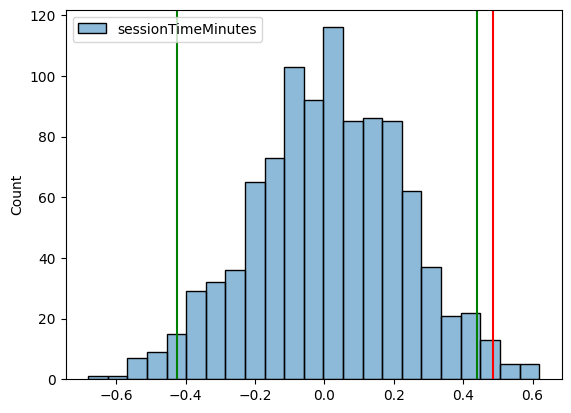

In [41]:
plt = sea.histplot(data=df)
plt.axvline(x=0.484411, ymin=0, ymax=1, color='red') # Observed difference
plt.axvline(x=-0.426334, ymin=0, ymax=1, color='green') # Threshold lower bound
plt.axvline(x=0.439625, ymin=0, ymax=1, color='green') # Threshold upper bound
plt

The observed difference is outside of our 95% confidence interval and is significant. This makes sense; version A was generated by multiplying 3 with randomly generated numbers between [0, 1] and version be was multiplied by 4.

## Statistical Significance and p-Values
Data analysts use statistical significance to determine if differences between groups are not explained by chance.

**p-value** is the probability of obtaining results as unusual as what we observe in our data sample *assuming* that the two data are produced by the same model.

**Alpha** is the threshold of how unusual the chance results must be to be considered significant.

**Type 1 error** is made when we determine an effect is real but it was caused by chance.

**Type 2 error** is made when we determine an effect is due to chance, but it was in fact real.

### Web Conversion Example
Imagine this fake example from the product price example given earlier.


Outcome --| Price A | Price B

Conversion | 200 -----| 182

None ----------| 25,539 | 22,406

Price A converts at 0.84% (200/(25539+200))*100%.

Price B converts at 0.80% (182/(22406+182))*100%.

Price A converts ~4% better than B. In a high volume business like Amazon, this could be a huge deal. The sample size of 45K rows tempts us to skip significance tests; instead when the changes are this small, it becomes all the more important.

Luckily, we can test if the difference between conversions is within the range of chance using a resampling procedure. This once again is a Null hypothesis check. Said a different way, "If the two prices actually have the same conversion rate, could chance produce a difference as big as 5%."

1. Put cards labeled 1 and 0 in a box to represent the shared conversion rate data. We will put in 382 "1" and 45,945 "0" cards and shuffle them.
2. Draw out a sample of size 23,739, i.e., the A prices, and record how many 1s are drawn.
3. Draw out a sample of size 22,588, i.e., the B prices, and record how many 0s are drawn.
4. Record the difference in the proportion of 1s.
5. Repeat.
6. Count how often the modified differences were greater than the observed difference of ~4% (0.0368 to be precise).

In [56]:
observedPercentDiff = 100 * (200 / 23739 - 182 / 22588) # 0.0368
conversion = [0] * 45945 # Zero cards
conversion.extend([1] * 382) # Append the one cards
conversion = pd.Series(conversion)
permutationDifferences = [100 * permutationTestIteration(conversion, 23739, 22588) for _ in range(1000)]
df = pd.DataFrame(permutationDifferences)
df.head()

,0
0,-0.017012
1,-0.045640
2,-0.062276
3,-0.023290
4,0.036758


<Axes: ylabel='Count'>

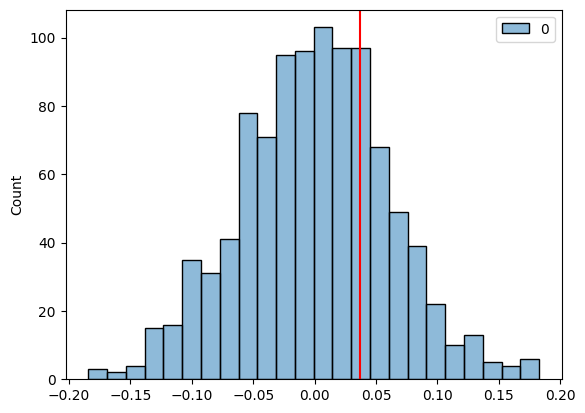

In [52]:
plt = sea.histplot(data=df)
plt.axvline(x=0.0368, ymin=0, ymax=1, color='red') # Observed difference
plt

Even without computing the 95% confidence interval, we can intuitively see that the observed difference is "within" the expected variation.

### p-Value
Eyeballing a graph isn't precise though and data analysts usually will rely on p-values. We can get a decent estimate using our permutation results by just counting the proportion of times that the permutation had a difference greater than the observed difference. (Notice that things flip if we observed a negative difference).

In [55]:
import numpy as np
np.mean([diff > observedPercentDiff for diff in permutationDifferences]) # This takes advantage of 1 being true and 0 being false

0.251

In other words we would expect a result as unusual as our observed result over 25% of the time. Alternatively we could use the binomial distribution to approximate a p-value.

## A Couple Thoughts on Alpha
"Statitisticians frown on the practice of leaving it to the researcher's discretion to determine whether a result is "too unusual" to happen by chance." -- Gedeck

Instead, we are told what the right thresholds are, usually 5% or 1%. Any number we pick is an arbitrary choice. Remember, that we are not answering the question "What is the probability that this happened by chance?" but instead the more subtle question of, "Given a chance model, what is the probability that this result is unusual." We then work backward how good of a fit that chance model is, but this judgement does not have a probability.

In March 2016, the American Statistical Association [updated its guidance](https://www.amstat.org/asa/files/pdfs/p-valuestatement.pdf) on statistical significance. One of the important points was, "Scientific conclusions and business or policy decisions should not be based only on whether a p-value passes a specific threshold."

Statistical significance does not equal "practical" significance. Micro differences of no practical meaning can be statistically significant if there is enough data to back it up. Differences that pass lower alphas can still be practical. If price B passed an alpha of 15% and had the chance to make the company $10M, executives may be interested in taking that risk.

"For a data scientist, a p-value is a useful metric in situations where you want to know whether a model result that appears interesting and useful is within the range of normal chance variability... p-value shold not be considered controlling but merely another point of information bearing on a decision." Gedeck